R => Python  
Source: https://web.stanford.edu/class/stats191/notebooks/Interactions.html

NOTE: 
* Not exactly porting R to Python.
* Also not [rpy2](https://rpy2.readthedocs.io/en/version_2.8.x/)

## Interactions and qualitative variables 

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.api import abline_plot

In [2]:
sm.version.version

'0.9.0'

In [3]:
import scipy; scipy.__version__

'0.18.1'

### Chapter 5, RABE

- Most variables we have looked at so far were continuous: `height`,
`rating`, etc.

- In many situations, we record a categorical variable: `sex` or `gender`, `state`, `country`, etc.

- We call these variables *categorical* or *qualtitative* variables.
In `R`, these are referred to as `factors`.

- For our purposes, we want to answer: **How do we include this in our model?**

This will eventually lead us to the notion of *interactions* and some special regression models called
*ANOVA* (analysis of variance) models.

### Two-sample problem

In some sense, we have already seen a regression model with categorical variables:
the two-sample model.

* Two sample problem with equal variances: suppose
$Z_j \sim N(\mu_1, \sigma^2), 1 \leq j \leq m$ and
$W_j \sim N(\mu_2, \sigma^2), 1 \leq j \leq n $.

* For $1 \leq i \leq n$, let 
$$X_i =
\begin{cases}
1 & 1 \leq i \leq m \\
0 & \text{otherwise.}
\end{cases}$$


The design matrix and response look like
$$ Y_{(n+m) \times 1} = 
\begin{pmatrix}
Z_1 \\
\vdots \\
Z_m \\
W_1 \\
\vdots \\
W_n \\
\end{pmatrix}, \qquad
X_{(n+m) \times 2} =
 \begin{pmatrix}
1 & 1 \\
 \vdots & \vdots \\
1 & 1 \\
1 & 0 \\
\vdots & \vdots \\
1 & 0
\end{pmatrix}$$

### Salary example

In this example, we have data on salaries of employees in IT (several years ago?) based on their years of experience, their
education level and whether or not they are management.

-   Outcome: `S`, salaries for IT staff in a corporation.

-   Predictors: 
    * `X`, experience (years)
    * `E`, education (1=Bachelor's, 2=Master's, 3=Ph.D)
    * `M`, management (1=management, 0=not management)

In [4]:
url = 'http://stats191.stanford.edu/data/salary.table'

In [5]:
salary_data = pd.read_table(url)
salary_data.head()

/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if __name__ == '__main__':


,S,X,E,M
0,13876,1,1,1
1,11608,1,3,0
2,18701,1,3,1
3,11283,1,2,0
4,11767,1,3,0


Let's take a quick look at how `R` treats a `factor`


In [6]:
# pd.Categorical: Represents a categorical variable in classic R / S-plus fashion
factor = pd.Categorical(salary_data.E)
factor

[1, 3, 3, 2, 3, ..., 2, 2, 1, 2, 1]
Length: 46
Categories (3, int64): [1, 2, 3]

In [7]:
factor.categories

Int64Index([1, 2, 3], dtype='int64')

Let's take a look at the data. We will use triangles for management, diamonds for non-management
red for education=1, green for education=2 and blue for education=3.


In [8]:
def plot_raw_data(data):
    symbols = ['D', '^'] #mgt or not
    colors = ['r', 'g', 'blue'] # bachelor vs. masters vs. ph.D
    factor_groups = data.groupby(['E','M'])
    for (edu, mgt), group in factor_groups:
        plt.scatter(group['X'], group['S'], marker=symbols[mgt], color=colors[edu-1], s=144)
    plt.xlabel('Experience')
    plt.ylabel('Salary')
    plt.title('Experience vs. Salary')
    plt.show()

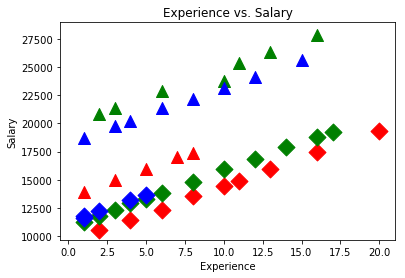

In [9]:
plot_raw_data(salary_data)

## Effect of experience

In these pictures, the slope of each line seems to be about the same. How might
we estimate it?

### One solution is *stratification*.

* Make six separate models (one for each combination of `E` and `M`) and estimate the slope.

* Combining them: we could average them?

* We have few degrees of freedom in each group.


### Or, use *qualitative* variables

-   IF it is reasonable to assume that $\sigma^2$ is constant for each
    observation.

-   THEN, we can incorporate all observations into 1 model.

$$S_i = \beta_0 + \beta_1 X_i + \beta_2 E_{i2} + \beta_3 E_{i3} + \beta_4 M_i + \varepsilon_i$$

Above, the variables are:

* $$
E_{i2} = \begin{cases}
1 & \text{if $E_i$=2} \\
0 & \text{otherwise.}
\end{cases}
$$

* $$
E_{i3} = \begin{cases}
1 & \text{if $E_i$=3} \\
0 & \text{otherwise.}
\end{cases}
$$

### Notes

-   Although $E$ has 3 levels, we only added 2 variables to the model.
    In a sense, this is because `(Intercept)` (i.e. $\beta_0$) absorbs one level.

-   If we added three variables then the columns of design matrix would
    be linearly dependent so we would not have a unique least squares solution.

-   Assumes $\beta_1$ â€“ effect of experience is the same in all groups,
    unlike when we fit the model separately. This may or may not be
    reasonable.


In [10]:
formula = 'S ~ C(E) + C(M) + X'

In [11]:
salary_res = ols(formula, data=salary_data).fit()
salary_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     226.8
Date:                Thu, 20 Jun 2019   Prob (F-statistic):           2.23e-27
Time:                        21:13:38   Log-Likelihood:                -381.63
No. Observations:                  46   AIC:                             773.3
Df Residuals:                      41   BIC:                             782.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8035.5976    386.689     20.781      0.000    7254.663    8816.532
C(E)[T.2]   3144.0352    361.968      8.686      0.000    2413.025    3875.045
C(E)[T.3]   2996.2103    411.753      7.277      0.000    2164.659    3827.762
C(M)[T.1]   6883.5310    313.919     21.928      0.000    6249.559    7517.503
X            546.1840     30.519     17.896      0.000     484.549     607.819
==============================================================================
Omnibus:                        2.293   Durbin-Watson:                   2.237
Prob(Omnibus):                  0.318   Jarque-Bera (JB):                1.362
Skew:                          -0.077   Prob(JB):                        0.506
Kurtosis:                       2.171   Cond. No.                         33.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, let's take a look at our design matrix

In [12]:
pd.DataFrame(salary_res.model.exog, columns=salary_res.model.exog_names).head() 

,Intercept,C(E)[T.2],C(E)[T.3],C(M)[T.1],X
0,1.0,0.0,0.0,1.0,1.0
1,1.0,0.0,1.0,0.0,1.0
2,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,1.0


Comparing to our actual data, we can understand how the columns above were formed. They were formed
just as we had defined them above.

In [13]:
salary_data.head()

,S,X,E,M
0,13876,1,1,1
1,11608,1,3,0
2,18701,1,3,1
3,11283,1,2,0
4,11767,1,3,0


### Effect of experience

-   Our model has enforced the constraint the $\beta_1$ is the same
    within each group.

-   Graphically, this seems OK, but how can we test this?

-   We could fit a model with different slopes in each group, but
    keeping as many degrees of freedom as we can.

-   This model has *interactions* in it: the effect of experience
    depends on what level of education you have.


### Interaction between experience and education

-   Model: $$\begin{aligned}
       S_i &= \beta_0 + \beta_1 X_i + \beta_2 E_{i2} + \beta_3 E_{i3} +\
 \beta_4 M_i \\
       & \qquad  + \beta_5 E_{i2} X_i + \beta_6 E_{i3} X_i + \varepsilon_i.
       \end{aligned}$$
       
- What is the regression function within each group?

-   Note that we took each column corresponding to education and
    multiplied it by the column for experience to get two new
    predictors.

-   To test whether the slope is the same in each group we would just
    test $H_0:\beta_5 = \beta_6=0$.

-   Based on figure, we expect not to reject $H_0$.

In [14]:
formula_interaction_X = "S ~ C(E) * X + C(M)" 

In [15]:
salary_res_interaction_X = ols(formula=formula_interaction_X, 
                               data=salary_data).fit()
salary_res_interaction_X.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     158.6
Date:                Thu, 20 Jun 2019   Prob (F-statistic):           8.23e-26
Time:                        21:13:38   Log-Likelihood:                -379.47
No. Observations:                  46   AIC:                             772.9
Df Residuals:                      39   BIC:                             785.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    7256.2800    549.494     13.205      0.000    6144.824    8367.736
C(E)[T.2]    4172.5045    674.966      6.182      0.000    2807.256    5537.753
C(E)[T.3]    3946.3649    686.693      5.747      0.000    2557.396    5335.333
C(M)[T.1]    7102.4539    333.442     21.300      0.000    6428.005    7776.903
X             632.2878     53.185     11.888      0.000     524.710     739.865
C(E)[T.2]:X  -125.5147     69.863     -1.797      0.080    -266.826      15.796
C(E)[T.3]:X  -141.2741     89.281     -1.582      0.122    -321.861      39.313
==============================================================================
Omnibus:                        0.432   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.806   Jarque-Bera (JB):                0.590
Skew:                           0.144   Prob(JB):                        0.744
Kurtosis:                       2.526   Cond. No.                         69.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
anova_lm(salary_res, salary_res_interaction_X)

/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,41.0,4.328072e+07,0.0,NaN,NaN,NaN
1,39.0,3.941068e+07,2.0,3.870040e+06,1.914856,0.160964


The notation `X:E` denotes an *interaction*. Generally, `R` will take the columns added for `E` and the columns added
for `X` and add their elementwise product (Hadamard product) to the design matr.x

Let's look at our design matrix again to be sure we understand what model was fit.

In [17]:
pd.DataFrame(salary_res_interaction_X.model.exog, 
             columns=salary_res_interaction_X.model.exog_names).iloc[9:20,:] 

,Intercept,C(E)[T.2],C(E)[T.3],C(M)[T.1],X,C(E)[T.2]:X,C(E)[T.3]:X
9,1.0,1.0,0.0,0.0,3.0,3.0,0.0
10,1.0,0.0,0.0,1.0,3.0,0.0,0.0
11,1.0,1.0,0.0,1.0,3.0,3.0,0.0
12,1.0,0.0,1.0,1.0,3.0,0.0,3.0
13,1.0,0.0,0.0,0.0,4.0,0.0,0.0
14,1.0,0.0,1.0,1.0,4.0,0.0,4.0
15,1.0,0.0,1.0,0.0,4.0,0.0,4.0
16,1.0,1.0,0.0,0.0,4.0,4.0,0.0
17,1.0,1.0,0.0,0.0,5.0,5.0,0.0
18,1.0,0.0,1.0,0.0,5.0,0.0,5.0


## Remember, it's still a model (i.e. a plane)

<img src="http://stats191.stanford.edu/figs/axes_multiple_full.svg" width="700">


### Interaction between management and education

* We can also test for interactions between qualitative variables.

* In our plot, note that Master's in management make more than PhD's in management, but this difference disappears in 
non-management.

* This means the effect of education is different in the two management levels. This is evidence of
an *interaction*.

* To see this, we plot the residuals within groups separately.

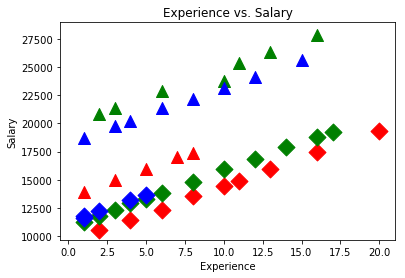

In [18]:
plot_raw_data(salary_data)

In [19]:
def plot_residuals(result, data):
    resid = result.resid
    symbols = ['D', '^'] #mgt or not
    colors = ['r', 'g', 'blue'] # bachelor vs. masters vs. ph.D
    factor_groups = data.groupby(['E','M'])
    for (edu, mgt), group in factor_groups:
        group_num = edu*2 + mgt - 1  # for plotting purposes
        x = [group_num] * len(group)
        plt.scatter(x, resid[group.index], marker=symbols[mgt], color=colors[edu-1], s=144)
    plt.xlabel('Group')
    plt.ylabel('Residuals')
    plt.title('Group vs. Residuals')
    plt.show()

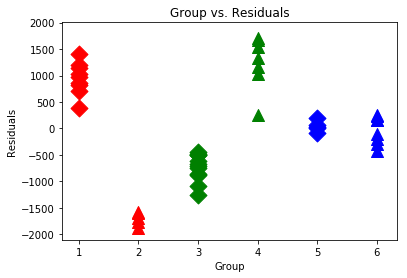

In [20]:
plot_residuals(result=salary_res, data=salary_data)

`R` has a special plot that can help visualize this effect, called an `interaction.plot`.


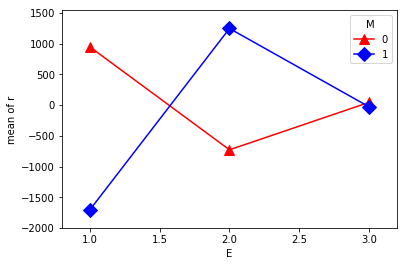

In [21]:
# Interaction plot for factor level statistics.
interaction_plot(x=salary_data["E"], 
                trace=salary_data["M"], 
                response=salary_res.resid, 
                colors=['red','blue'], 
                markers=['^','D'],
                markersize=10, 
                ax=plt.gca())
plt.ylabel("mean of r")
plt.show()

### Interaction between management and education

-   Based on figure, we expect an interaction effect.

-   Fit model $$\begin{aligned}
       S_i &= \beta_0 + \beta_1 X_i + \beta_2 E_{i2} + \beta_3 E_{i3} +\
 \beta_4 M_i \\
       & \qquad  + \beta_5 E_{i2} M_i + \beta_6 E_{i3} M_i + \varepsilon_i.
       \end{aligned}$$

-   Again, testing for interaction is testing $H_0:\beta_5=\beta_6=0.$

- What is the regression function within each group?

In [22]:
formula_interaction_EM = "S ~ X + C(E) * C(M)" 

In [23]:
salary_res_interaction_EM = ols(formula=formula_interaction_EM, 
                               data=salary_data).fit()
salary_res_interaction_EM.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5517.
Date:                Thu, 20 Jun 2019   Prob (F-statistic):           1.67e-55
Time:                        21:13:40   Log-Likelihood:                -298.74
No. Observations:                  46   AIC:                             611.5
Df Residuals:                      39   BIC:                             624.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            9472.6854     80.344    117.902      0.000    9310.175    9635.196
C(E)[T.2]            1381.6706     77.319     17.870      0.000    1225.279    1538.063
C(E)[T.3]            1730.7483    105.334     16.431      0.000    1517.690    1943.806
C(M)[T.1]            3981.3769    101.175     39.351      0.000    3776.732    4186.022
C(E)[T.2]:C(M)[T.1]  4902.5231    131.359     37.322      0.000    4636.825    5168.222
C(E)[T.3]:C(M)[T.1]  3066.0351    149.330     20.532      0.000    2763.986    3368.084
X                     496.9870      5.566     89.283      0.000     485.728     508.246
==============================================================================
Omnibus:                       74.761   Durbin-Watson:                   2.244
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1037.873
Skew:                          -4.103   Prob(JB):                    4.25e-226
Kurtosis:                      24.776   Cond. No.                         79.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
anova_lm(salary_res, salary_res_interaction_EM)

/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,41.0,4.328072e+07,0.0,NaN,NaN,NaN
1,39.0,1.178168e+06,2.0,4.210255e+07,696.844466,3.025504e-31


Let's look at our design matrix again to be sure we understand what model was fit.


In [25]:
pd.DataFrame(salary_res_interaction_EM.model.exog, 
             columns=salary_res_interaction_EM.model.exog_names).head(6) 

,Intercept,C(E)[T.2],C(E)[T.3],C(M)[T.1],C(E)[T.2]:C(M)[T.1],C(E)[T.3]:C(M)[T.1],X
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,1.0,1.0,0.0,1.0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0
5,1.0,1.0,0.0,1.0,1.0,0.0,2.0


We will plot the residuals as functions of experience
with each *experience* and *management* having a 
different symbol/color.

In [26]:
def plot_residuals_studentized(result, data):
    """
    The standardized residual is the residual divided by its standard deviation.

    formula: standard_residual_i = residual_i / standard_deviation_of_residual_i
    """
    infl = result.get_influence()
    resid_studentized = infl.summary_frame()["standard_resid"]
    symbols = ['D', '^'] #mgt or not
    colors = ['r', 'g', 'blue'] # bachelor vs. masters vs. ph.D
    factor_groups = data.groupby(['E','M'])
    for (edu, mgt), group in factor_groups:
        i = group.index
        plt.scatter(data.X[i], resid_studentized[i], marker=symbols[mgt], color=colors[edu-1], s=144)
    plt.xlabel('X')
    plt.ylabel('standardized resids')
    plt.title('X vs. Standardized Residuals')
    plt.show()
    return resid_studentized

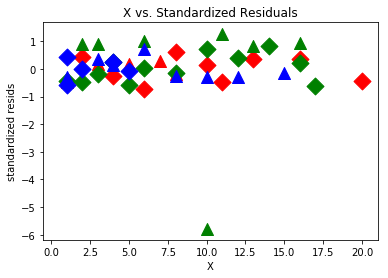

In [27]:
resid_studentized = plot_residuals_studentized(salary_res_interaction_EM, salary_data)

One observation seems to be an outlier.



In [28]:
# Test observations for outliers according to method
# Return table columns are the Studentized residuals, the unadjusted p-value, 
# and the corrected p-value according to method.
# by default, method='bonf'
# by default, cutoff=None

salary_res_interaction_EM.outlier_test(cutoff=0.05)

# Source: https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.outlier_test.html

,student_resid,unadj_p,bonf(p)
32,-14.950832,1.676948e-17,7.713960e-16


Default value for cutoff in outlierTest is 0.05.

Source: https://www.rdocumentation.org/packages/car/versions/3.0-2/topics/outlierTest

Let's refit our model to see that our conclusions are not vastly different.



In [29]:
def rm_outlier(result, data):
    drop_idx = abs(result).argmax()
    print("drop index: ",drop_idx)  # zero-based index
    idx = data.index.drop(drop_idx)
    return drop_idx, idx # subset of data after dropping outlier

In [30]:
def fit_linear_model(formula, data, subset=None):
    """
    Fitting models using R-style formula
    For categorical variables; use C() operator
    """
    res_lm = ols(formula, data, subset).fit()
    return res_lm

In [31]:
drop_idx, idx = rm_outlier(resid_studentized, data=salary_data)

drop index:  32


/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  from ipykernel import kernelapp as app


In [32]:
# after dropping outlier
res_lm_subset = fit_linear_model(formula=formula, 
                                data=salary_data, 
                                subset=idx)

res_lm_interaction_X_subset = fit_linear_model(formula=formula_interaction_X,
                                            data=salary_data,
                                            subset=idx)

res_lm_interaction_EM_subset = fit_linear_model(formula=formula_interaction_EM,
                                            data=salary_data,
                                            subset=idx)


Let's replot the residuals

/home/doojung/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


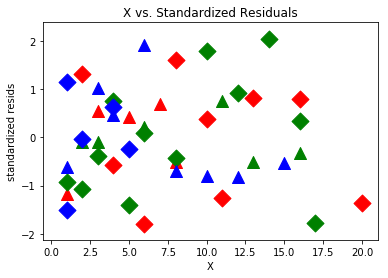

In [33]:
resid_studentized_subset = plot_residuals_studentized(result=res_lm_interaction_EM_subset, 
                                            data=salary_data)


Let's make a final plot of the fitted values.


In [34]:
def plot_fitted_values(formula, data, drop_idx=None, subset=None):
    """
    this time, data = data.drop([drop_idx]))
    """
    drop_idx = drop_idx
    data = data.drop([drop_idx])
    lm_final = fit_linear_model(formula=formula, data=data)
    
    mf = lm_final.model.data.orig_exog
    lstyle = ['-','--'] #mgt or not
    symbols = ['D', '^'] #mgt or not
    colors = ['r', 'g', 'blue'] # bachelor vs. masters vs. ph.D
    factor_groups = data.groupby(['E','M'])
    for (edu, mgt), group in factor_groups:
        idx = group.index
        plt.scatter(data.X[idx], data.S[idx], marker=symbols[mgt], color=colors[edu-1], s=144)

        # drop NA because there is no idx 32 in the final model
        plt.plot(mf.X[idx].dropna(), lm_final.fittedvalues[idx].dropna(),
                ls=lstyle[mgt], color=colors[edu-1])
    plt.xlabel('Experience')
    plt.ylabel('Salary')
    plt.show()

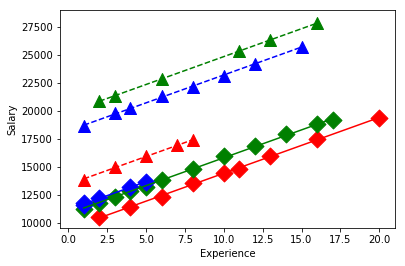

In [35]:
plot_fitted_values(formula=formula_interaction_EM, 
                   data=salary_data, 
                   drop_idx=drop_idx)

### Visualizing an interaction

From our first look at the data, the difference between 
Master's and PhD in the
management group is different than in the non-management
group. This is an interaction between the two qualitative
variables
*management,M* and *education,E*. We can visualize this
by first removing the effect of experience, then plotting
the means within each of the 6 groups using *interaction.plot*.

In [36]:
U = salary_data.S - salary_data.X * res_lm_interaction_X_subset.params['X']

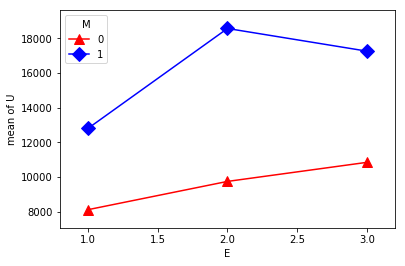

In [37]:
interaction_plot(x=salary_data.E, 
                trace=salary_data.M, 
                response=U, 
                colors=['red','blue'], 
                markers=['^','D'],
                markersize=10, 
                ax=plt.gca())
plt.ylabel("mean of U")
plt.show()

### Jobtest employment data (RABE)

<table>
<tr><td><b>Variable</b></td><td><b>Description</b></td></tr>
<tr><td>TEST</td><td>Job aptitude test score</td></tr>
<tr><td>MINORITY</td><td>1 if applicant could be considered minority, 0 otherwise</td></tr>
<tr><td>PERF</td><td>Job performance evaluation</td></tr>
</table>

In [38]:
url = 'http://stats191.stanford.edu/data/jobtest.table'

In [39]:
jobtest_data = pd.read_table(url)
print(jobtest_data.head())

/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if __name__ == '__main__':


   TEST  MINORITY  JPERF
0  0.28         1   1.83
1  0.97         1   4.59
2  1.25         1   2.97
3  2.46         1   8.14
4  2.51         1   8.00


In [40]:
# pd.Categorical: Represents a categorical variable in classic R / S-plus fashion
jobtest_factor = pd.Categorical(jobtest_data.MINORITY)
jobtest_factor

[1, 1, 1, 1, 1, ..., 0, 0, 0, 0, 0]
Length: 20
Categories (2, int64): [0, 1]

Since I will be making several plots, it will be easiest to attach `jobtest.table` though I will detach it later.

**These plots would be easier with `ggplot`.**


In [41]:
def plot_data(data):
    factor_group = data.groupby(['MINORITY'])
    fig, ax = plt.subplots(figsize=(6,6))
    colors = ['purple', 'green']
    markers = ['o', 'v']
    for factor, group in factor_group:
        ax.scatter(group['TEST'], 
                group['JPERF'], 
                color=colors[factor],
                marker=markers[factor], 
                s=12**2)
    ax.set_xlabel('TEST')
    ax.set_ylabel('JPERF')
    return fig, ax

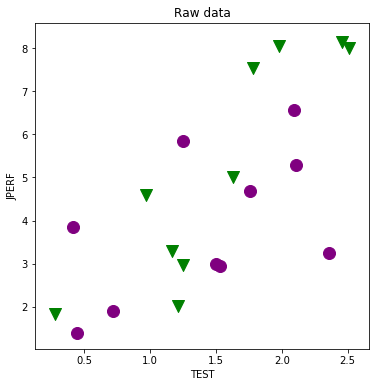

In [42]:
plot_data(jobtest_data)
plt.title("Raw data")
plt.show()

### General model

-   In theory, there may be a linear relationship between $JPERF$ and
    $TEST$ but it could be different by group.

-   Model:
    $$JPERF_i = \beta_0 + \beta_1 TEST_i + \beta_2 MINORITY_i + \beta_3 MINORITY_i * TEST_i + \varepsilon_i.$$

-   Regression functions:
   $$
   Y_i =
   \begin{cases}
   \beta_0 + \beta_1 TEST_i + \varepsilon_i & \text{if $MINORITY_i$=0} \\
   (\beta_0 + \beta_2) + (\beta_1 + \beta_3) TEST_i + \varepsilon_i & \text{if 
$MINORITY_i=1$.} \\
   \end{cases}
   $$





### Our first model: ($\beta_2=\beta_3=0$)

This has no effect for `MINORITY`.


In [43]:
formula_first = 'JPERF ~ TEST'
first_res = ols(formula_first, data=jobtest_data).fit()
first_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  JPERF   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     19.25
Date:                Thu, 20 Jun 2019   Prob (F-statistic):           0.000356
Time:                        21:13:44   Log-Likelihood:                -36.614
No. Observations:                  20   AIC:                             77.23
Df Residuals:                      18   BIC:                             79.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0350      0.868      1.192      0.249      -0.789       2.859
TEST           2.3605      0.538      4.387      0.000       1.230       3.491
==============================================================================
Omnibus:                        0.324   Durbin-Watson:                   2.896
Prob(Omnibus):                  0.850   Jarque-Bera (JB):                0.483
Skew:                          -0.186   Prob(JB):                        0.785
Kurtosis:                       2.336   Cond. No.                         5.26
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

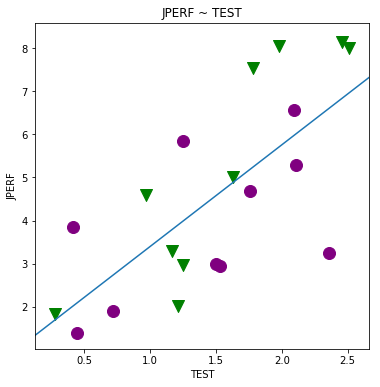

In [44]:
fig, ax = plot_data(jobtest_data)
fig = abline_plot(model_results = first_res, ax=ax)
plt.title("JPERF ~ TEST")
plt.show()

### Our second model ($\beta_3=0$)

This model allows for an effect of `MINORITY` but no interaction between `MINORITY` and `TEST`.


In [45]:
formula_second = 'JPERF ~ TEST + MINORITY'
second_res = ols(formula_second, data=jobtest_data).fit()
second_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  JPERF   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     11.38
Date:                Thu, 20 Jun 2019   Prob (F-statistic):           0.000731
Time:                        21:13:45   Log-Likelihood:                -35.390
No. Observations:                  20   AIC:                             76.78
Df Residuals:                      17   BIC:                             79.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6120      0.887      0.690      0.500      -1.260       2.483
TEST           2.2988      0.522      4.400      0.000       1.197       3.401
MINORITY       1.0276      0.691      1.487      0.155      -0.430       2.485
==============================================================================
Omnibus:                        0.251   Durbin-Watson:                   3.028
Prob(Omnibus):                  0.882   Jarque-Bera (JB):                0.437
Skew:                          -0.059   Prob(JB):                        0.804
Kurtosis:                       2.286   Cond. No.                         5.72
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

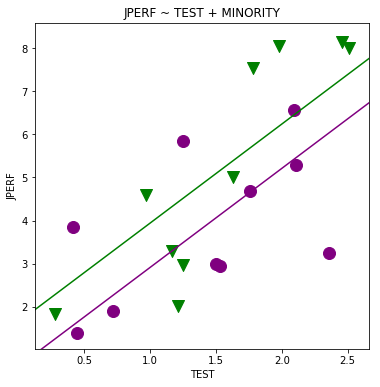

In [46]:
fig, ax = plot_data(jobtest_data)
fig = abline_plot(intercept = second_res.params['Intercept'],
                slope = second_res.params['TEST'], 
                ax=ax, color='purple')

fig = abline_plot(intercept = second_res.params['Intercept'] + second_res.params['MINORITY'],
                slope = second_res.params['TEST'], 
                ax=ax, color='green')

plt.title("JPERF ~ TEST + MINORITY")
plt.show()

### Our third model $(\beta_2=0)$:

This model includes an interaction between `TEST` and `MINORITY`. These lines have the same intercept but possibly different slopes within the `MINORITY` groups.

In [47]:
formula_third = "JPERF ~ TEST + TEST:MINORITY"
third_res = ols(formula_third, data=jobtest_data).fit()
third_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  JPERF   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     14.59
Date:                Thu, 20 Jun 2019   Prob (F-statistic):           0.000204
Time:                        21:13:46   Log-Likelihood:                -33.891
No. Observations:                  20   AIC:                             73.78
Df Residuals:                      17   BIC:                             76.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.1211      0.780      1.437      0.169      -0.525       2.768
TEST              1.8276      0.536      3.412      0.003       0.698       2.958
TEST:MINORITY     0.9161      0.397      2.306      0.034       0.078       1.754
==============================================================================
Omnibus:                        0.388   Durbin-Watson:                   3.008
Prob(Omnibus):                  0.823   Jarque-Bera (JB):                0.514
Skew:                           0.050   Prob(JB):                        0.773
Kurtosis:                       2.221   Cond. No.                         5.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

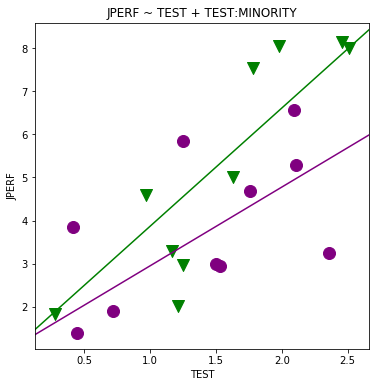

In [48]:
fig, ax = plot_data(jobtest_data)
fig = abline_plot(intercept = third_res.params['Intercept'],
                slope = third_res.params['TEST'], 
                ax=ax, color='purple')

fig = abline_plot(intercept = third_res.params['Intercept'],
                slope = third_res.params['TEST'] + third_res.params['TEST:MINORITY'],
                ax=ax, color='green')

plt.title("JPERF ~ TEST + TEST:MINORITY")
plt.show()

Let's look at our design matrix again to be sure we understand which model was fit.



In [49]:
pd.DataFrame(third_res.model.exog, columns=third_res.model.exog_names).head(6)

,Intercept,TEST,TEST:MINORITY
0,1.0,0.28,0.28
1,1.0,0.97,0.97
2,1.0,1.25,1.25
3,1.0,2.46,2.46
4,1.0,2.51,2.51
5,1.0,1.17,1.17


### Our final model: no constraints

This model allows for different intercepts and different slopes.


In [50]:
formula_fourth = "JPERF ~ TEST * MINORITY"
fourth_res = ols(formula_fourth, data=jobtest_data).fit()
fourth_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  JPERF   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     10.55
Date:                Thu, 20 Jun 2019   Prob (F-statistic):           0.000451
Time:                        21:13:46   Log-Likelihood:                -32.971
No. Observations:                  20   AIC:                             73.94
Df Residuals:                      16   BIC:                             77.92
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.0103      1.050      1.914      0.074      -0.216       4.236
TEST              1.3134      0.670      1.959      0.068      -0.108       2.735
MINORITY         -1.9132      1.540     -1.242      0.232      -5.179       1.352
TEST:MINORITY     1.9975      0.954      2.093      0.053      -0.026       4.021
==============================================================================
Omnibus:                        3.377   Durbin-Watson:                   3.015
Prob(Omnibus):                  0.185   Jarque-Bera (JB):                1.330
Skew:                           0.120   Prob(JB):                        0.514
Kurtosis:                       1.760   Cond. No.                         13.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

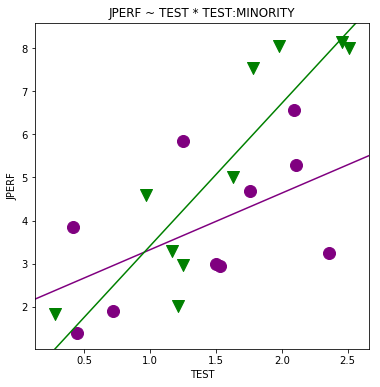

In [51]:
fig, ax = plot_data(jobtest_data)
fig = abline_plot(intercept = fourth_res.params['Intercept'],
                slope = fourth_res.params['TEST'], 
                ax=ax, color='purple')

fig = abline_plot(intercept = fourth_res.params['Intercept'] + fourth_res.params['MINORITY'],
                slope = fourth_res.params['TEST'] + fourth_res.params['TEST:MINORITY'],
                ax=ax, color='green')
plt.title("JPERF ~ TEST * TEST:MINORITY")
plt.show()

The expression `TEST*MINORITY` is shorthand for `TEST + MINORITY + TEST:MINORITY`.


In [52]:
pd.DataFrame(fourth_res.model.exog, columns=fourth_res.model.exog_names).head(6)

,Intercept,TEST,MINORITY,TEST:MINORITY
0,1.0,0.28,1.0,0.28
1,1.0,0.97,1.0,0.97
2,1.0,1.25,1.0,1.25
3,1.0,2.46,1.0,2.46
4,1.0,2.51,1.0,2.51
5,1.0,1.17,1.0,1.17


### Comparing models

Is there any effect of MINORITY on slope or intercept?


In [53]:
table = anova_lm(first_res, fourth_res)
print("TEST vs. TEST * MINORITY")
print(table)

TEST vs. TEST * MINORITY
   df_resid        ssr  df_diff    ss_diff         F    Pr(>F)
0      18.0  45.568297      0.0        NaN       NaN       NaN
1      16.0  31.655473      2.0  13.912824  3.516061  0.054236


/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Is there any effect of MINORITY on intercept? (Assuming we have accepted the hypothesis that the slope is the same within
each group).

In [54]:
table = anova_lm(first_res, second_res)
print("TEST vs. TEST + MINORITY")
print(table)

TEST vs. TEST + MINORITY
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0      18.0  45.568297      0.0       NaN       NaN       NaN
1      17.0  40.321546      1.0  5.246751  2.212087  0.155246


/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


We could also have allowed for the possiblity that the slope is different within each group and still check for a different intercept.


In [55]:
table = anova_lm(third_res, fourth_res)
print("TEST + TEST:MINORITY vs. TEST * MINORITY")
print(table)

TEST + TEST:MINORITY vs. TEST * MINORITY
   df_resid        ssr  df_diff  ss_diff         F    Pr(>F)
0      17.0  34.707653      0.0      NaN       NaN       NaN
1      16.0  31.655473      1.0  3.05218  1.542699  0.232115


/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Is there any effect of `MINORITY` on slope?  (Assuming we have accepted the hypothesis that the intercept is the same within each
group).


In [56]:
table = anova_lm(first_res, third_res)
print("TEST vs. TEST + TEST * MINORITY")
print(table)

TEST vs. TEST + TEST * MINORITY
   df_resid        ssr  df_diff    ss_diff         F    Pr(>F)
0      18.0  45.568297      0.0        NaN       NaN       NaN
1      17.0  34.707653      1.0  10.860644  5.319603  0.033949


/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Again, we could have allowed for the possibility that the intercept is different within each group.



In [57]:
table = anova_lm(second_res, fourth_res)
print("TEST + MINORITY vs. TEST * MINORITY")
print(table)

TEST + MINORITY vs. TEST * MINORITY
   df_resid        ssr  df_diff   ss_diff         F   Pr(>F)
0      17.0  40.321546      0.0       NaN       NaN      NaN
1      16.0  31.655473      1.0  8.666073  4.380196  0.05265


/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In summary, without taking the several tests into account here, there does seem to be some evidence
that the  slope is different within the two groups.

## Model selection

Already with this simple dataset (simpler than the IT salary data) we have 4 competing models. How are we going
to arrive at a final model? 

This highlights the need for *model selection*. We will come to this topic shortly.